### Esteban Gomez Buitrago
#### Z5627462

# Assingment 1: Drought Neural Network

In Australia there are multiple regions that produce important quantities of food and fibre, and one of the most important ones is the Murray-Darling Basin. Unfortunately, this region is really prone to droughts that can have a devastating effect in its agricultural sector. In effect, finding a way of predicting these droughts in order to be prepared for them is absolutely fundamental. The objective of this project is to create a neural network that is capable of predicting droughts and their intensities based on some variables from the area (including mean sea level pressure, minimum temperature at 2 meters, beneath others). 

To create the model that will be able to complete the task, the first thing we will have to do is install the necessary libraries. In this case, due to some compatibility problems we had to install them through the virtual environment, this is why we have all the installation lines commented (they're already installed).

In [6]:
#import sys
#print(sys.version)

In [7]:
#!pip uninstall -y tensorflow
#!pip install tensorflow==2.17

In [8]:
#pip install numpy

In [9]:
#pip install matplotlib

In [10]:
#pip install tensorflow

In [11]:
#pip install pandas

In [12]:
#pip install scikit-learn

In [13]:
#pip install seaborn

After installing the libraries we need to import the pertinent packages and functions.

In [15]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
print("NumPy version:", np.__version__)
print("Matplotlib version:", mpl.__version__)
print("TensorFlow version:", tf.__version__)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, mean_absolute_error
from scipy.stats import pearsonr 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

NumPy version: 1.24.3
Matplotlib version: 3.6.3
TensorFlow version: 2.13.0


Now we will create a seed in order to be able to reproduce the results every time we do a "random" action.

In [17]:
np.random.seed(42)  

## Classification Task

Our first task is to create a model that is able to identify if there will be drought or not depending on some features.

To create the model we will have to save all the data into a variable.

In [20]:
data = pd.read_csv('Climate_SPI.csv')
#To check if it is the correct data
#print(data.head())

We need to calculate "Drought" variable based on climate data predictors. In this case we will use the SPI (Standarize Precipitation Index) to find a target variable. We will consider -1 as the threshold to SPI: <br> A value less than or equal to -1 will mean that there is Drought, and a value greater than -1 means no Drought condition.


In [22]:
# Create the 'Drought' variable

data['Drought'] = (data['SPI'] <= -1).astype(int)

# To check if the new column is correct.
print(data[['SPI', 'Drought']].head())


        SPI  Drought
0 -0.715037        0
1 -0.246504        0
2 -0.921090        0
3 -0.917537        0
4  0.631926        0


In order to determine the relevance of each feature and be able to decide which one to keep in the model we used a correlation matrix (we will look only into the correlation of each variable with the SPI). It's important to highlight that we took this only as a reference, we still used some not to correlated variables.

In [24]:
correlation_matrix = data.corr()
spi_correlations = correlation_matrix[['SPI']]
print(spi_correlations)

              SPI
year    -0.092378
month   -0.010873
u10     -0.079859
v10     -0.168374
mx2t    -0.101818
mn2t     0.017701
tcc      0.451987
t2      -0.038729
msl     -0.126847
t       -0.027723
q        0.359705
u       -0.054631
v       -0.107164
z       -0.125496
SPI      1.000000
grid_ID -0.004405
Drought -0.662388


The next step that we will take is dropping out the variables that we are not going to consider. We dropped put our target variable, SPI as it is the actual answer, and the variables that have no or too litle correlation with SPI. After exclusing these variable we will save the actual features data in "X" and the target data in "y" and we will create tensorflow arrays that relate each data with its actual target data. Afterwards, we will divide the data set into 3 groups that are going to help us to train the neural network, the training, validation and test sets. 

The training set will be the set that the model actually sees and trains on (learns patterns, feautures, relationships, etc). The validation set allows us to see how the model performs on unseen data, that way giving us information about which parameters we could adjust. Finally, the test set helps us to see the final performance of the already trained set (how it performs on new data after being trained). 

In [26]:
#In case we wanted to use month we would have to normalize it in this way

# Normalize month to [0, 2π]
#data["month_normalized"] = 2 * np.pi * (data["month"] - 1) / 12

# Replace 'month' with cyclic features
#data["cos_month"] = np.cos(data["month_normalized"])
#data["sin_month"] = np.sin(data["month_normalized"])

# We drop the columns that are not part of our climate variables
X = data.drop(columns=["year", "grid_ID", "Drought", "SPI", "month"])
# Our target variable
y = data["Drought"]

# Convert the DataFrame to a TensorFlow dataset
# We will end up with an array with a vector from x with its respective label from y
dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))

# Shuffle the dataset, this is a good practice when training
dataset = dataset.shuffle(buffer_size=len(data), seed=42)

total_samples = len(data)
# Calculate the sizes for the splits
train_size = int(0.8 * total_samples)
validation_size = int(0.1 * total_samples)

# Split the dataset into training, validation, and test sets
# take function gives back a set with the first specified number of elements
# skip function stays with all the elements after skipping the first specified number
train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)

#Now we take the number needed for val_dataset from the remaining that are stored in temp_dataset
val_dataset = temp_dataset.take(validation_size)

#The remaining will be for test
test_dataset = temp_dataset.skip(validation_size)


# Check the sizes of the splits
print(f'Training set size: {train_size}')
print(f'Validation set size: {validation_size}')
print(f'Test set size: {total_samples - train_size - validation_size}')

Training set size: 12096
Validation set size: 1512
Test set size: 1512


Now to continue with our model we must normalize the data we have, as these models are really sensitive to the magnitudes.

In [28]:
normalizer_c = Normalization()
#We will adapt the Normalizer to the train set for it to be able to automatically normalize all future inputs
#We will adapt it only to the train set and apply the same normalization to the validation and test sets
X_train = X.values[:train_size] #the first train_size number of values are the ones in train_dataset 
normalizer_c.adapt(X_train)

# Now the normalizer have been adapted, so we can create a function to normalize the dataset
def preprocess_c(features, labels):
    #print("Original features shape:", features.shape)
    features = normalizer_c(features) 
    features = tf.squeeze(features)  # This will remove dimensions of size 1 (some times they get added during the batching)
    return features, labels
    
for features, labels in train_dataset.take(1):
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

# Go in groups of 32
batch_size= 32

# Apply normalization to the training, validation, and test datasets (the .map apply the transformation, and returns a new transformed dataset)
# It is important to drop the remainder as the batches cannot have different sizes
train_dataset = train_dataset.map(preprocess_c).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.map(preprocess_c).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.map(preprocess_c).batch(batch_size, drop_remainder=True)

for features, labels in train_dataset.take(1):
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")
    
#for X_batch, y_batch in train_dataset.take(1):
 #   print("Features:", X_batch)
 #   print("Labels:", y_batch)


Features shape: (12,), Labels shape: ()
Features shape: (32, 12), Labels shape: (32,)


After having all the data normalized we can define the architecture and hyperparameters of our model. We will have to test multiple configurations until finding the one that suits us best.

In [30]:
# We use the sequential model and Dense(number_of_neurons, role, number of features)
classification_model = Sequential()
classification_model.add(Dense(32, activation='relu', input_dim=X.shape[1]))  # First hidden layer, first layer is implicitly defined by input_dim
classification_model.add(Dense(16, activation='relu'))  # Second hidden layer
#classification_model.add(Dense(8, activation='relu'))  # third hidden layer
classification_model.add(Dense(1, activation='sigmoid'))  # Output layer for 1 or 0 scenario (binary), for this reason we use sigmoid

# Compile the model with optimizer, loss function, and metrics
# Optimizer: which algorithm to use in order to update the weights. -sgd or adam
# Loss Function: it defines what the model seeks to minimize. -binary_crossentropy or mean_squared_error
# Metrics: What we're going to look at in order to evaluate the performance of the model
classification_model.compile(loss="binary_crossentropy", 
                             optimizer= Adam(learning_rate=0.001), 
                             metrics=["accuracy"]) #Accuracy= Number of Correct Predictions/Total Number of Predictions
# Go 40 times through the data
epochs = 40
history = classification_model.fit(train_dataset,
                                    validation_data=val_dataset,
                                    epochs=epochs)
# Save the trained model
classification_model.save("classification_model.h5")

Epoch 1/40
378/378 [==============================] - 4s 6ms/step - loss: 0.3895 - accuracy: 0.8488 - val_loss: 0.3692 - val_accuracy: 0.8477
Epoch 2/40
378/378 [==============================] - 2s 5ms/step - loss: 0.3501 - accuracy: 0.8533 - val_loss: 0.3085 - val_accuracy: 0.8717
Epoch 3/40
378/378 [==============================] - 2s 5ms/step - loss: 0.3312 - accuracy: 0.8620 - val_loss: 0.3266 - val_accuracy: 0.8664
Epoch 4/40
378/378 [==============================] - 2s 5ms/step - loss: 0.3256 - accuracy: 0.8615 - val_loss: 0.3268 - val_accuracy: 0.8624
Epoch 5/40
378/378 [==============================] - 2s 6ms/step - loss: 0.3144 - accuracy: 0.8676 - val_loss: 0.2980 - val_accuracy: 0.8737
Epoch 6/40
378/378 [==============================] - 2s 6ms/step - loss: 0.3141 - accuracy: 0.8664 - val_loss: 0.3263 - val_accuracy: 0.8557
Epoch 7/40
378/378 [==============================] - 2s 4ms/step - loss: 0.3115 - accuracy: 0.8672 - val_loss: 0.3012 - val_accuracy: 0.8803
Epoch 

C:\Users\Esteban\anaconda3\envs\AI_env3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


It is recommended that the network has fewer 
parameters than the number of samples divided by 10 We will check it:.

In [32]:
#This will give a summary of the parameters per layer
classification_model.summary()

total_samples = train_size
threshold = total_samples / 10

#This will be the total of parameters
num_parameters = classification_model.count_params()

# Check if the model meets the recommendation
if num_parameters < threshold:
    print("Model has fewer parameters than samples/10.")
else:
    print("Model has too many parameters.")
    
print(f"Number of Parameters: {num_parameters}, Threshold: {threshold}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model has fewer parameters than samples/10.
Number of Parameters: 961, Threshold: 1209.6


No we will evaluate the performance on validation set by comparing the accuracy of both the training and validation sets over each iteration of the data.

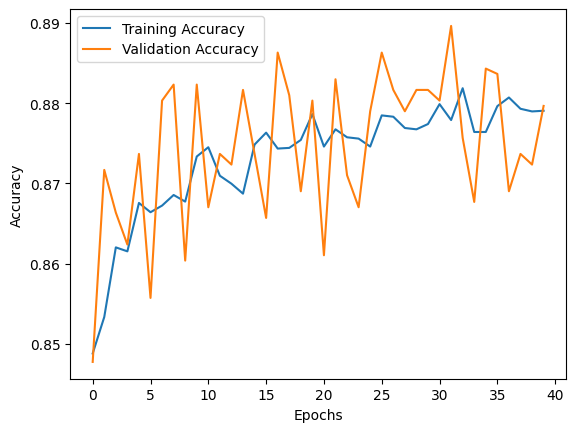

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Finally we will create a confusion matrix in order to see how is the performance of the trained model on a completely new set (the test set). This matrix will show us the exact number of right and wrong guesses that our model had. It will also allow us to see the percentage of successes (Accuracy), and the percentage of times that it said there was drought and there was actually drought (precision) from all of his drought guesses.

47/47 [==============================] - 1s 3ms/step
Length of true labels (y_true): 1504
Length of predicted labels (y_pred): 1504


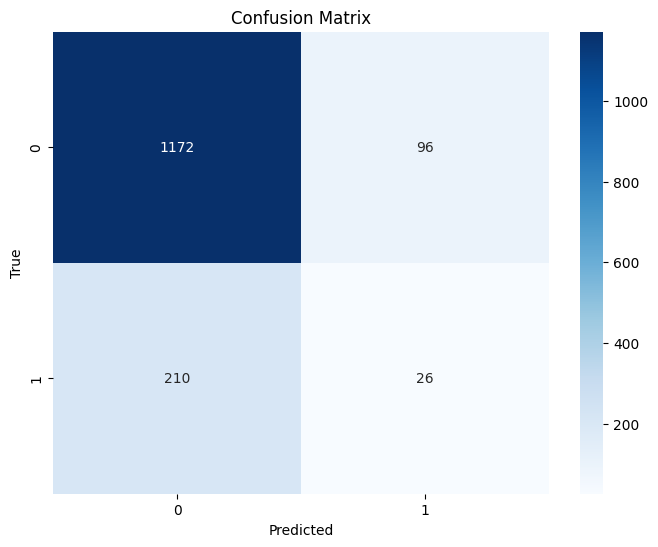

Balanced Accuracy: 0.5172298561728065
Precision: 0.21311475409836064


In [36]:
# Predict on the test set
y_pred_prob = classification_model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to class predictions and flatten

# Extract true labels from the test dataset
y_true = []
for feature, label in test_dataset:
    y_true.extend(label.numpy())  # Collect true labels in a list
y_true = np.array(y_true)  # Convert to a numpy array from tensor

# Now check the lengths of y_true and y_pred
print(f"Length of true labels (y_true): {len(y_true)}")
print(f"Length of predicted labels (y_pred): {len(y_pred)}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Compute Balanced Accuracy and Precision
balanced_acc = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')


## Regression Task

Now we would like to train a model that based on some variables, is able to identify the potetnial intensity of a drought (this will be defined by its SPI). In order to achieve this we will follow a similar process to the one from the previous model (there will only be a couple of key differences).

First we will import the pertinent packages.

In [39]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
print("NumPy version:", np.__version__)
print("Matplotlib version:", mpl.__version__)
print("TensorFlow version:", tf.__version__)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, mean_absolute_error
from scipy.stats import pearsonr 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

NumPy version: 1.24.3
Matplotlib version: 3.6.3
TensorFlow version: 2.13.0


We will download the data.

In [41]:
data = pd.read_csv("Climate_SPI.csv")
#To check if it is the correct data
#print(data.head())

Equally as in the last model now we have to drop the non used variables, define out target variable, split the sets and create the model with the best possible configuration of hyperparameters and its architecture values.

The key differences we will have here is that our target variable will be the "SPI" as we want the model to learn to approximate this value from other's variables information in order to know how strong a drought will be. In the same way, after an intensive analysis we find out that a different  architecture and configuration of hyperparameters would lead us to better results with this model.

In [43]:
# We drop the columns that are not part of our climate variables
X = data.drop(columns=["year", "grid_ID", "SPI", "month", "t", "t2"])
# Our target variable
y = data["SPI"]

# Convert the DataFrame to a TensorFlow dataset
# We will end up with an array with a vector from x with its respective label from y
dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))

# Shuffle the dataset, this is a good practice when training
dataset = dataset.shuffle(buffer_size=len(data), seed=40)

# Determine the size of the dataset
total_samples = len(data)

# Calculate the sizes for the splits
train_size = int(0.8 * total_samples)
validation_size = int(0.1 * total_samples)

# Split the dataset into training, validation, and test sets
train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(validation_size)
test_dataset = temp_dataset.skip(validation_size)

# Check the sizes of the splits
print(f'Training set size: {train_size}')
print(f'Validation set size: {validation_size}')
print(f'Test set size: {total_samples - train_size - validation_size}')

normalizer_r = Normalization()
X_train = X.values[:train_size]
normalizer_r.adapt(X_train)

# Create normalizer function
def preprocess_r(features, labels):
    #print("Original features shape:", features.shape)
    features = normalizer_r(features) 
    features = tf.squeeze(features) 
    return features, labels
    
for features, labels in train_dataset.take(1):
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

batch_size=32

# Apply normalization
train_dataset = train_dataset.map(preprocess_r).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.map(preprocess_r).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.map(preprocess_r).batch(batch_size, drop_remainder=True)

for features, labels in train_dataset.take(1):
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

# Define the model
classification_model_r = Sequential()
classification_model_r.add(Dense(32, activation="relu", input_dim=X.shape[1]))  # First hidden layer, first layer is implicitly defined by input_dim
classification_model_r.add(Dense(16, activation= "relu"))  # Second hidden layer
classification_model_r.add(Dense(8, activation= "relu")) # Third Layer
classification_model_r.add(Dense(1))

classification_model_r.compile(loss="mean_squared_error", 
                             optimizer= Adam(learning_rate=0.001), 
                             metrics=["mean_absolute_error"]) 
# Go 40 times through the data
epochs = 40
history = classification_model_r.fit(train_dataset,
                                    validation_data=val_dataset,
                                    epochs=epochs)
# Save the trained model
classification_model_r.save("Regression_model.h5")

Training set size: 12096
Validation set size: 1512
Test set size: 1512
Features shape: (10,), Labels shape: ()
Features shape: (32, 10), Labels shape: (32,)
Epoch 1/40
378/378 [==============================] - 4s 6ms/step - loss: 0.6927 - mean_absolute_error: 0.6583 - val_loss: 0.5300 - val_mean_absolute_error: 0.5770
Epoch 2/40
378/378 [==============================] - 2s 5ms/step - loss: 0.5346 - mean_absolute_error: 0.5783 - val_loss: 0.5306 - val_mean_absolute_error: 0.5771
Epoch 3/40
378/378 [==============================] - 2s 6ms/step - loss: 0.5115 - mean_absolute_error: 0.5660 - val_loss: 0.4916 - val_mean_absolute_error: 0.5553
Epoch 4/40
378/378 [==============================] - 2s 5ms/step - loss: 0.4937 - mean_absolute_error: 0.5542 - val_loss: 0.5219 - val_mean_absolute_error: 0.5680
Epoch 5/40
378/378 [==============================] - 2s 6ms/step - loss: 0.4805 - mean_absolute_error: 0.5470 - val_loss: 0.4606 - val_mean_absolute_error: 0.5350
Epoch 6/40
378/378 [===

C:\Users\Esteban\anaconda3\envs\AI_env3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In order to have a graphic representation on how the model is performing on unseen data we will create a graph with bothe the training and validation loss over each epoch.

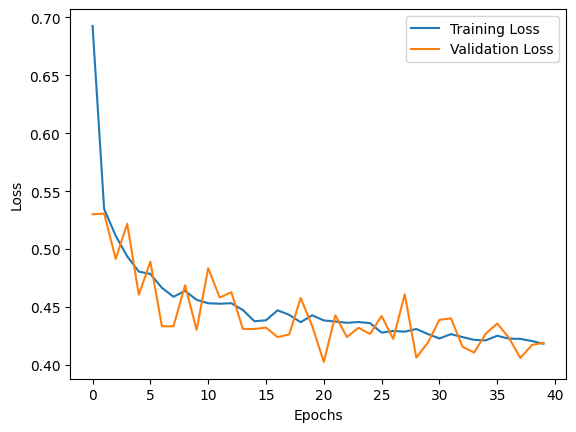

In [45]:
# Plot the loss and accuracy
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally, we will plot the real values of the SPI compared to the values that were predicted by our trained model when giving him new data (the test set). This will help us to see what is the performance of our trained model. From this information we will also look at the mean absolute error that tells us in average how far away of the actual value our predictions where. And also we will look at the Pearson Correlation Coefficient that describes how related are true values from the predictions.

47/47 [==============================] - 1s 4ms/step


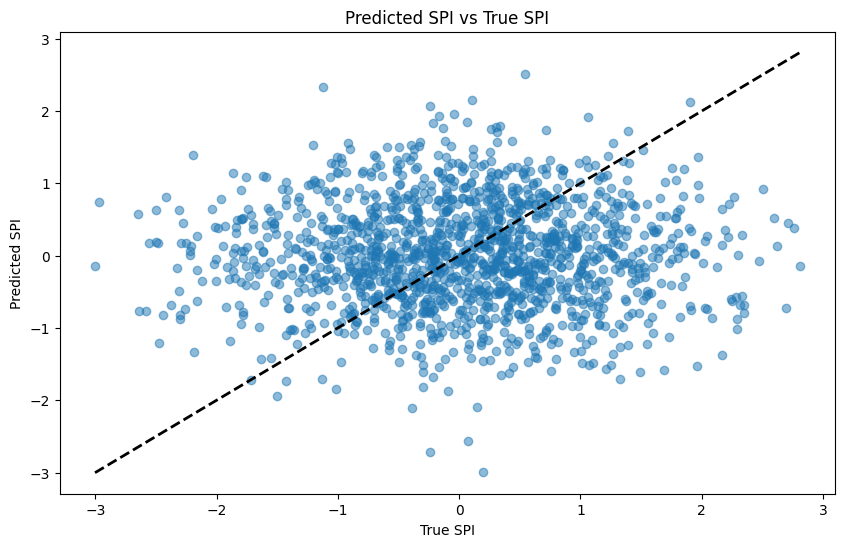

Mean Absolute Error (MAE): 0.9814688715509227
Pearson Correlation Coefficient: 0.003484565442859383


In [47]:
# Use your model to predict SPI on the test set
y_pred = classification_model_r.predict(test_dataset)
y_pred = y_pred.flatten() #to convert an array in 1D (format needed to be able to plot)

# Get true labels for the test set
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("True SPI")
plt.ylabel("Predicted SPI")
plt.title("Predicted SPI vs True SPI")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "k--", lw=2)  # Diagonal line
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(y_true, y_pred)
print(f"Pearson Correlation Coefficient: {pearson_corr}")

## Evaluating Model in New Data Set

Finally we will create a code that is able to apply the previously created model to a new set of data. For this we will only have to ensure that the new dataset have the same features to the set our model trained with.

63/63 [==============================] - 0s 3ms/step


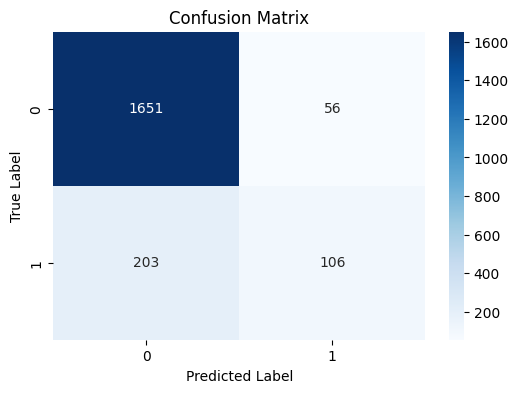

Balanced Accuracy: 0.6551
Precision: 0.6543
Number of samples: 2016
Model's predictors set: ['u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z']


In [60]:
# read new data
new_data = pd.read_csv("Climate_SPI3.csv")

# Ensure that we have the same features
new_data["Drought"] = (new_data["SPI"] <= -1).astype(int)

X_new = new_data.drop(columns=["year", "Drought", "grid_ID", "SPI", "month"]) 
y_new = new_data["Drought"] 

# Normalize the data
dataset_new = tf.data.Dataset.from_tensor_slices((X_new.values, y_new.values))
batch_size = 32
X_new_normalized = dataset_new.map(preprocess_c).batch(batch_size, drop_remainder=True)

# Apply the model
classification_model = tf.keras.models.load_model("classification_model.h5")
predictions = classification_model.predict(X_new_normalized)
predicted_classes = np.round(predictions).astype(int)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_new[:len(predicted_classes)], predicted_classes)  #As we dropped a couple of samples with the remainder
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

balanced_acc = balanced_accuracy_score(y_new[:len(predicted_classes)], predicted_classes)
precision = precision_score(y_new[:len(predicted_classes)], predicted_classes)

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")

print(f"Number of samples: {len(X_new)}")
print(f"Model's predictors set: {list(X_new.columns)}")


We will follow the same process for our regression model

63/63 [==============================] - 1s 4ms/step


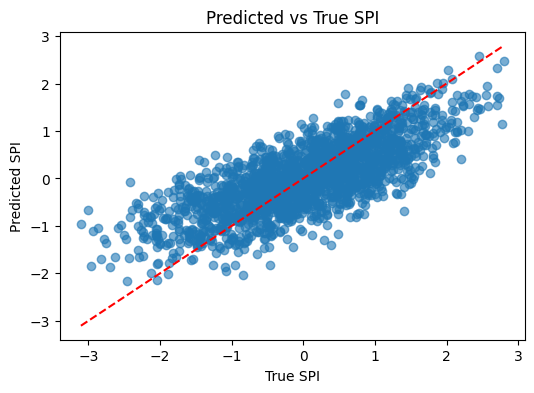

Mean Absolute Error: 0.5198
Pearson Correlation Coefficient: 0.7522
Number of samples: 2016
Model's predictors set: ['u10', 'v10', 'mx2t', 'mn2t', 'tcc', 'msl', 'q', 'u', 'v', 'z']


In [62]:
new_data = pd.read_csv("Climate_SPI1.csv")
X_new = new_data.drop(columns=["year", "grid_ID", "SPI", "month", "t", "t2"])
y_new = new_data["SPI"]

dataset_new = tf.data.Dataset.from_tensor_slices((X_new.values, y_new.values))
batch_size = 32
X_new_normalized = dataset_new.map(preprocess_r).batch(batch_size, drop_remainder=True)

regression_model = tf.keras.models.load_model("Regression_model.h5")
y_pred = regression_model.predict(X_new_normalized)

plt.figure(figsize=(6, 4))
plt.scatter(y_new[:len(y_pred)], y_pred, alpha=0.6)
plt.plot([min(y_new[:len(y_pred)]), max(y_new[:len(y_pred)])], [min(y_new[:len(y_pred)]), max(y_new[:len(y_pred)])], "r--") 
plt.xlabel("True SPI")
plt.ylabel("Predicted SPI")
plt.title("Predicted vs True SPI")
plt.show()

mae = mean_absolute_error(y_new[:len(y_pred)], y_pred)
pearson_corr, _ = pearsonr(y_new[:len(y_pred)], y_pred.flatten())

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

print(f"Number of samples: {len(X_new)}")
print(f"Model's predictors set: {list(X_new.columns)}")